# Social Reward Modeling

We will define a generative model, where the learning rate will be fixed instead of estimated from participants' data. Value and prediction error signals from this model will be explored in the brain. 

## Set Up

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt


### Set Paths

In [4]:
proj_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
data_dir = os.path.join(proj_dir, 'derivatives', 'task_socialreward', 'data')
outp_dir = os.path.join(proj_dir, 'derivatives', 'rl_modeling')

os.chdir(proj_dir)

### Find Participants

In [5]:
# Import participant id data
subj_df = pd.read_csv(proj_dir+'participants.tsv', sep='\t')

# Fix participant IDs to match the directories in the data folder (e.g. sub-SCN101 -> SCN_101)
subj_df['participant_id'] = [x[4:7]+'_'+x[7:] for x in subj_df['participant_id']]


print('Found '+str(len(subj_df))+' participants')

Found 85 participants


In [6]:
subj_df

,participant_id,group
0,SCN_101,1
1,SCN_102,1
2,SCN_103,1
3,SCN_104,1
4,SCN_105,2
...,...,...
80,SCN_222,1
81,SCN_223,2
82,SCN_225,1
83,SCN_227,1


## Defining the Reinforcement Learning Model

This function takes as input a trial list, which contains information about the conditions (similar, dissimilar, or computer), and feedback (thumbs up or down) for each trial, and returns the following outputs: expected value of the three conditinos on each trial, and reward prediction error. 

In [7]:
def rl_model(trial_list, alpha):
    
    # Define an empty dataframe for the value of each condition at each trial 
    V = pd.DataFrame(columns=['SimPeer', 'DisPeer', 'Computer'], 
                     index=range(len(trial_list)))
    
    
    # Define intitional condition values for similar, dissimilar, and computer
    V.loc[0, ['SimPeer', 'DisPeer', 'Computer']] = 0.5
    trial_list['Value'] = 0.5
    
    
    RPE = np.empty(len(trial_list))
    trial_list['RPE'] = 0
    
    
    for t in range(len(trial_list)):
        cond_t = trial_list.loc[t, 'Peer']
        
        value_t = V.loc[t, cond_t]
        
        feedback_t = trial_list.loc[t, 'Feedback']
        
        # If received no feedback on the trial, RPE = 0
        if np.isnan(feedback_t):
            RPE[t] = 0
        else:
            RPE[t] = feedback_t - value_t

        
        # Update value of current condition
        V.loc[t+1, cond_t] = V.loc[t, cond_t] + alpha * RPE[t]
        if t > 0:
            trial_list.loc[t, 'Value'] = V.loc[t, cond_t]
        
        # Copy over value of all other conditions
        V.loc[t+1, V.columns != cond_t] = V.loc[t, V.columns != cond_t]
    
    RL_output = V.iloc[:-1].copy()
    RL_output['RPE'] = RPE
    trial_list['RPE'] = RPE
    
    return RL_output, trial_list

# Single Subject Analysis

In [8]:
subj = 'SCN_101'

# Find data for all runs
run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
run_files.sort()
run_files

['/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run1-errors.csv',
 '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run2-errors.csv',
 '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run3-errors.csv',
 '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/derivatives/task_socialreward/data/SCN_101/SR_SCN_101_Run4-errors.csv']

In [9]:
all_run_data = pd.DataFrame()

for file in run_files:
    if 'original' in file:
        continue
    temp_run = pd.read_csv(file, index_col=0)
    all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

# Create column for peer info
all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

# Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

# Mark missed response trials with NaN for the feedback (because no feedback was given)
all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan


all_run_data.head()

,ParticipantID,Run,Condition,ConditionName,Question,QuestionNumber,peerName,left_or_right,FirstButtonPressTime,CorrectButtonPressTime,...,FixDur,FixEnd,item_x,valence,item_y,rating,valence_redcap,redcap_v_task,Peer,Feedback
0,SCN_101,1,2,LowReward_SimPeer,like non-fiction,19.0,Shiloh,R,9.210867,9.210867,...,5.000847,5.017456,like non-fiction,pos,19,5,pos,0,SimPeer,0.0
1,SCN_101,1,0,LowReward_DisPeer,like yard sales,78.0,Charlie,R,19.992227,19.992227,...,NaN,NaN,like yard sales,pos,78,5,pos,0,DisPeer,0.0
2,SCN_101,1,5,HighReward_SimPeer,like laser tag,91.0,Shiloh,L,30.790777,30.790777,...,NaN,NaN,like laser tag,pos,91,5,pos,0,SimPeer,1.0
3,SCN_101,1,0,LowReward_DisPeer,like cooking,122.0,Charlie,L,43.877158,43.877158,...,NaN,NaN,like cooking,pos,122,5,pos,0,DisPeer,0.0
4,SCN_101,1,0,LowReward_DisPeer,don't play video games,209.0,Charlie,R,57.538735,57.538735,...,NaN,NaN,don't play video games,neg,209,2,neg,0,DisPeer,0.0


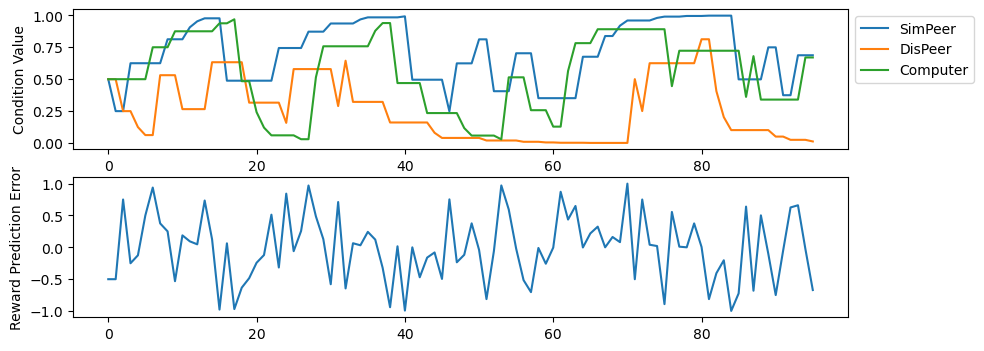

In [10]:
rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)


fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,4))

sns.lineplot(rl_output[['SimPeer', 'DisPeer', 'Computer']], dashes=False, ax=ax1)
ax1.set_ylabel('Condition Value')
sns.move_legend(ax1, "upper left", bbox_to_anchor=(1,1))

sns.lineplot(rl_output['RPE'], dashes=False, ax=ax2)
ax2.set_ylabel('Reward Prediction Error')

plt.subplots_adjust(wspace=0.8)

# All Subjects

In [13]:
for subj in subj_df['participant_id']:
    subj_outp_dir = os.path.join(outp_dir, subj)
    if not os.path.exists(subj_outp_dir):
        os.makedirs(subj_outp_dir)
    
    run_files = glob.glob(os.path.join(data_dir,subj,'*-errors.csv'))
    run_files.sort()
    
    if len(run_files) == 0:
        continue
    
    
    all_run_data = pd.DataFrame()

    for file in run_files:
        if 'original' in file:
            run_files.remove(file)
            continue
        temp_run = pd.read_csv(file, index_col=0)
        all_run_data = pd.concat([all_run_data, temp_run], ignore_index=True)

    # Create column for peer info
    all_run_data['Peer'] = [x.split('_')[1] for x in all_run_data['ConditionName']]

    # Create feedback column of 1s and 0s for thumbs up and thumbs down, respectively
    all_run_data['Feedback'] = [x.split('_')[0] for x in all_run_data['ConditionName']]
    all_run_data['Feedback'] = all_run_data['Feedback'].replace(['LowReward', 'HighReward'], [0, 1])

    # Mark missed response trials with NaN for the feedback (because no feedback was given)
    all_run_data.loc[all_run_data['Correct_RT'].isna(), 'Feedback'] = np.nan
    
    
    rl_output, all_run_data_rl = rl_model(all_run_data, alpha=0.5)
    rl_output.to_csv(os.path.join(subj_outp_dir, 'rl_output-all_runs.csv'), index=False)
    
    for file in run_files:
        run_str = file.split('Run')[1][0]
        temp_run_data = all_run_data_rl[all_run_data_rl['Run'] == int(run_str)]
        temp_file_name = file.split('/')[-1]
        temp_run_data.to_csv(os.path.join(subj_outp_dir, temp_file_name), index=False)